In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# p : X -> [0,1]
# Sigmoid function is monotonic
def p(x):
    return 1 / (1 + np.exp(-x))

def expected(x, plus, minus):
    return p(x) * plus + (1-p(x)) * minus

def opt_step(X, u_plus, u_minus, c_plus, c_minus):
    return [x + expected(x, c_plus, c_minus) for x in X if expected(x, u_plus, u_minus) > 0]

def fair_opt_step(A, B, u_plus, u_minus, c_plus, c_minus, alpha):
    a_threshholds = np.sort(A)
    b_threshholds = np.sort(B)
    max_util =  -np.inf
    opt_a, opt_b = None, None
    updated_samples = None
    prob = 0.4

    w_a = len(A) / (len(A) + len(B))
    w_b = len(B) / (len(A) + len(B))

    for i in a_threshholds:
        a = []
        for sample in A:
            w = sample + expected(sample, c_plus, c_minus)
            if w < i:
                a.append(sample)
            elif w == i:
                if np.random.rand() < prob:
                    a.append(w)
                else:
                    a.append(sample)
            else:
                a.append(w)

        for j in b_threshholds:
            b = []
            for sample in B:
                w = sample + expected(sample, c_plus, c_minus)
                if w < j:
                    b.append(sample)
                elif sample == j:
                    if np.random.rand() < prob:
                       b.append(w) 
                    else:
                        b.append(sample)
                else:
                    b.append(w)

            if (np.abs(np.mean(a) - np.mean(b))) <= alpha:
                util = w_a * expected(np.mean(a), u_plus, u_minus) + w_b * expected(np.mean(b), u_plus, u_minus)
                max_util = max(max_util, util)
                if max_util == util:
                    opt_a, opt_b = i, j
                    updated_samples = (a,b)
            else:
                continue
    return (opt_a, opt_b, max_util, updated_samples)

[np.float64(1.280951387953075), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747), np.float64(1.5209513879530747)]


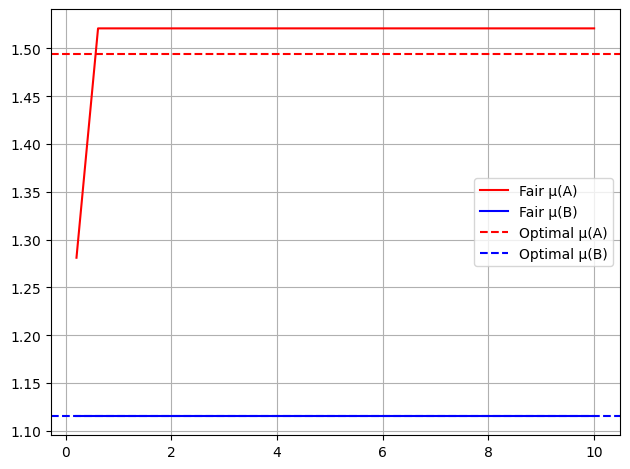

In [6]:
n_samples = 50 
mean_a, std_a = 0.5, 1
mean_b, std_b = 0, 1
x_min, x_max = -10, 10 

A = np.random.normal(mean_a, std_a, n_samples)
B = np.random.normal(mean_b, std_b, n_samples)

x = np.linspace(x_min, x_max, num=n_samples)

x1 = []
y1 = []
y2 = []
y3 = np.mean(opt_step(A, 1, -1, 1, -1))
y4 = np.mean(opt_step(B, 1, -1, 1, -1))

for i in x:
    samples = fair_opt_step(A, B, 1, -1, 1, 1, alpha=i)[3]
    if samples is not None:
        x1.append(i)
        y1.append(np.mean(samples[0]))
        y2.append(np.mean(samples[1]))
    else:
        continue

print(y1)
plt.plot(x1, y1, label="Fair μ(A)", color='red')
plt.plot(x1, y2, label="Fair μ(B)", color='blue')
plt.axhline(y3, color='red', linestyle='--', label='Optimal μ(A)')
plt.axhline(y4, color='blue', linestyle='--', label='Optimal μ(B)')

plt.legend()
plt.grid(True)
plt.tight_layout()


0.16533310685345276 -0.03812252753051393 3.9642157890409293
0.09706682444219972 0.560010461235852


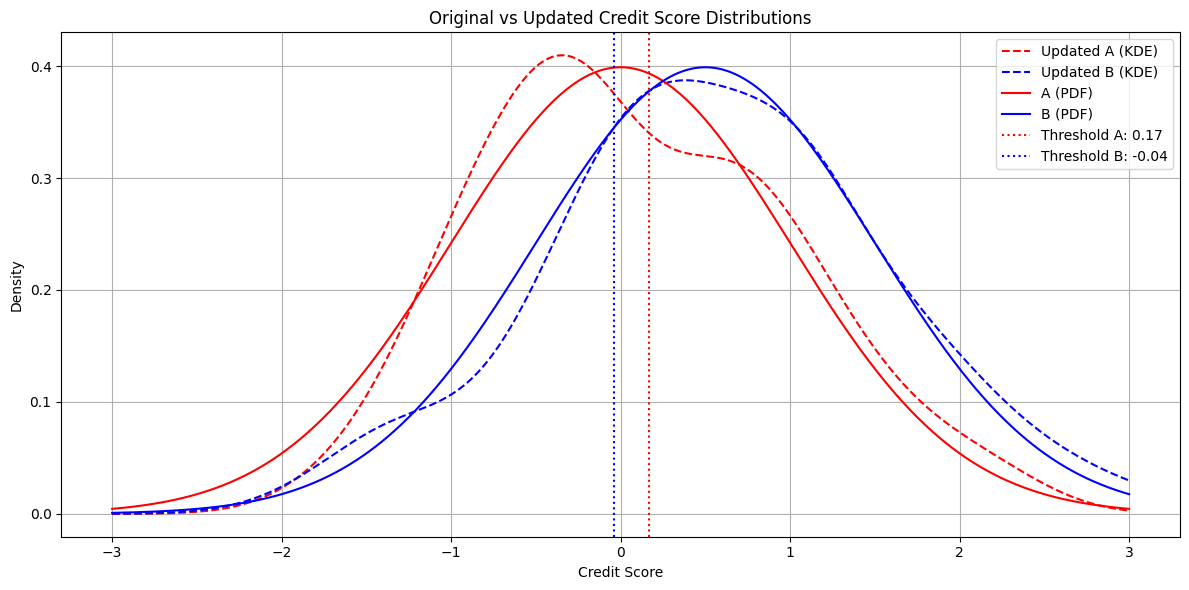

In [7]:

# Sample
n_samples = 100
A = np.random.normal(0, 1, n_samples)
B = np.random.normal(0.5, 1, n_samples)

# Run optimization step
opt_a, opt_b, max_util, updated_samples = fair_opt_step(A, B, 9, -3, .1, -.1, 0.5)
a, b = updated_samples

print(opt_a, opt_b, max_util)
print(np.mean(a), np.mean(b))

x_min = -3
x_max = 3

# KDE for updated A and B
kde_a = gaussian_kde(a)
x_a = np.linspace(x_min, x_max, 1000)
y_a = kde_a(x_a)

kde_b = gaussian_kde(b)
x_b = np.linspace(x_min, x_max, 1000)
y_b = kde_b(x_b)

# Theoretical distributions
mean_a, std_a = 0, 1
mean_b, std_b = 0.5, 1
x = np.linspace(x_min, x_max, 1000)
pdf_a = norm.pdf(x, mean_a, std_a)
pdf_b = norm.pdf(x, mean_b, std_b)

plt.figure(figsize=(12, 6))

# Plot updated KDE distributions
plt.plot(x_a, y_a, label='Updated A (KDE)', color='red', linestyle='--')
plt.plot(x_b, y_b, label='Updated B (KDE)', color='blue', linestyle='--')

# Plot original theoretical PDFs
plt.plot(x, pdf_a, label='A (PDF)', color='red', linestyle='-')
plt.plot(x, pdf_b, label='B (PDF)', color='blue', linestyle='-')

# Thresholds
plt.axvline(opt_a, color='red', linestyle=':', label=f'Threshold A: {opt_a:.2f}')
plt.axvline(opt_b, color='blue', linestyle=':', label=f'Threshold B: {opt_b:.2f}')

# Final plot settings
plt.title("Original vs Updated Credit Score Distributions")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()